# Build Your First Text Classification model using PyTorch



>Table of Contents <br>
>1.Why PyTorch for Text Classification? <br>

>Dealing with Out of Vocabulary words <br>
>Handling Variable Length sequences  <br>
>Wrappers and Pre-trained models   <br>
<br>
>2.Understanding the Problem Statement   <br>
>3.Implementation – Text Classification in PyTorch <br>


https://www.analyticsvidhya.com/blog/2020/01/first-text-classification-in-pytorch/

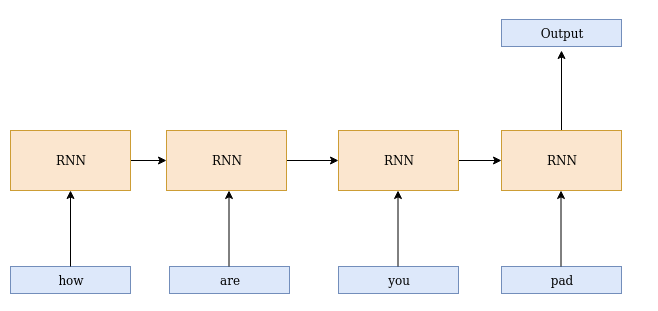

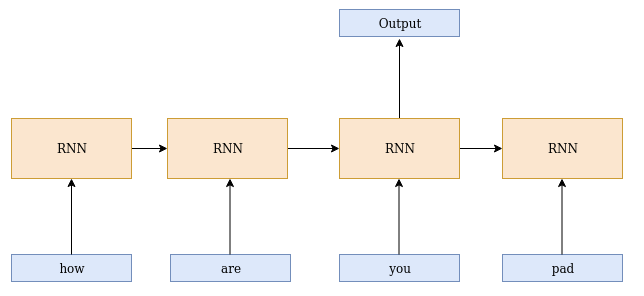

link: https://www.kaggle.com/c/quora-insincere-questions-classification/data

## File descriptions
- train.csv - the training set
- test.csv - the test set
- sample_submission.csv - A sample submission in the correct format
- enbeddings/ - (see below)

In [19]:
#deal with tensors
import torch   

#handling text data
from torchtext import data   

from tqdm.notebook import tqdm

In [2]:
#Reproducing same results
SEED = 2019

#Torch
torch.manual_seed(SEED)

#Cuda algorithms
torch.backends.cudnn.deterministic = True  

!pip3 install -U spacy <br/>
!python3 -m spacy download en_core_web_sm


# import spacy
# spacy.load('en_core_web_sm')

--------- spacy ---------------------------
- !pip3 install -U spacy
- !python3 -m spacy download en_core_web_sm




> qid                  ,question_text                                                         ,target
===========================================================================================================
>00002165364db923c7e6,How did Quebec nationalists see their province as a nation in the 1960s?,0 <br>
>000032939017120e6e44,"Do you have an adopted dog, how would you encourage people to adopt and not shop?",0 <br>


###  DATA 

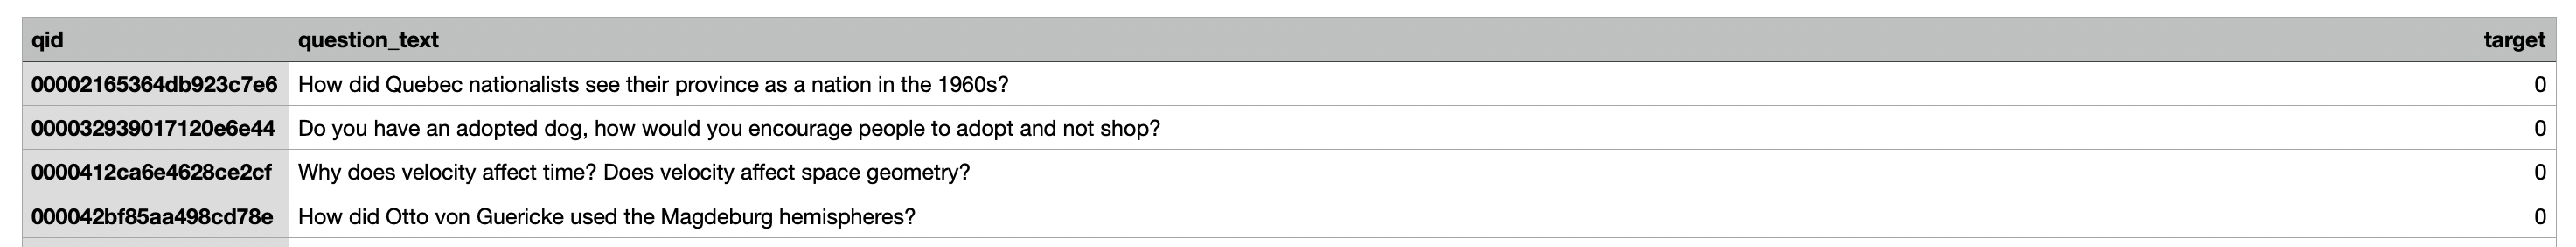


In [3]:
TEXT = data.Field(tokenize='spacy',batch_first=True,include_lengths=True)
LABEL = data.LabelField(dtype = torch.float,batch_first=True)

fields = [(None, None), ('text',TEXT),('label', LABEL)]

***Parameters of Field:***

    Tokenize:  specifies the way of tokenizing the sentence i.e. converting sentence to words. I am using spacy tokenizer since it uses novel tokenization algorithm <br> 
    
    ***Lower:*** converts text to lowercase <br>
    ***batch_first:*** The first dimension of input and output is always batch size
    


In [4]:
#loading custom dataset
training_data=data.TabularDataset(path = 'quora/train.csv',format = 'csv',fields = fields,skip_header = True)

#print preprocessed text
print(vars(training_data.examples[0]))

{'text': ['How', 'did', 'Quebec', 'nationalists', 'see', 'their', 'province', 'as', 'a', 'nation', 'in', 'the', '1960s', '?'], 'label': '0'}


In [5]:
print(vars(training_data.examples[1]))

{'text': ['Do', 'you', 'have', 'an', 'adopted', 'dog', ',', 'how', 'would', 'you', 'encourage', 'people', 'to', 'adopt', 'and', 'not', 'shop', '?'], 'label': '0'}


In [6]:
import random
train_data, test_data = training_data.split(split_ratio=0.7, random_state = random.seed(SEED)) #### test 20% 나뉘기, 섞기

In [7]:
print("Train:",len(train_data))
print("test_data",len(test_data))

Train: 914285
test_data 391837


In [8]:
#initialize glove embeddings
TEXT.build_vocab(train_data,min_freq=3,vectors = "glove.6B.100d")  
LABEL.build_vocab(train_data)

#No. of unique tokens in text
print("Size of TEXT vocabulary:",len(TEXT.vocab))

#No. of unique tokens in label
print("Size of LABEL vocabulary:",len(LABEL.vocab))

#Commonly used words
print(TEXT.vocab.freqs.most_common(10))  

#Word dictionary
print(TEXT.vocab.stoi)   

Size of TEXT vocabulary: 67216
Size of LABEL vocabulary: 2
[('?', 966749), ('the', 459069), ('What', 303343), ('to', 284435), ('a', 282614), ('in', 257009), ('is', 235794), ('of', 233261), ('I', 231119), ('How', 184012)]
defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x1f63eebd0>>, {'<unk>': 0, '<pad>': 1, '?': 2, 'the': 3, 'What': 4, 'to': 5, 'a': 6, 'in': 7, 'is': 8, 'of': 9, 'I': 10, 'How': 11, 'and': 12, 'do': 13, ',': 14, 'are': 15, 'for': 16, 'you': 17, 'Why': 18, 'it': 19, 'can': 20, 'Is': 21, 'that': 22, 'my': 23, '.': 24, 'with': 25, 'on': 26, 'be': 27, 'or': 28, 'have': 29, '"': 30, "'s": 31, 'does': 32, 'from': 33, 'your': 34, 'an': 35, 'if': 36, 'best': 37, 'get': 38, '-': 39, ')': 40, 'people': 41, 'as': 42, 'some': 43, '(': 44, 'Can': 45, 'there': 46, 'would': 47, 'not': 48, 'like': 49, 'should': 50, 'when': 51, 'Which': 52, 'at': 53, "n't": 54, 'about': 55, 'they': 56, 'by': 57, 'Do': 58, 'any': 59, 'we': 60, 'what': 61, 'was': 62,

In [10]:
#check whether cuda is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#set batch size
BATCH_SIZE = 64

#Load an iterator
train_iterator, valid_iterator = data.BucketIterator.splits(
    (train_data, test_data), 
    batch_size = BATCH_SIZE,
    sort_key = lambda x: len(x.text),
    sort_within_batch=True,
    device = device)

In [11]:
print(type(train_iterator))
print(type(valid_iterator))

print(vars(train_iterator))

<class 'torchtext.data.iterator.BucketIterator'>
<class 'torchtext.data.iterator.BucketIterator'>
{'batch_size': 64, 'train': True, 'dataset': <torchtext.data.dataset.Dataset object at 0x1f63e8290>, 'batch_size_fn': None, 'iterations': 0, 'repeat': False, 'shuffle': True, 'sort': False, 'sort_within_batch': True, 'sort_key': <function <lambda> at 0x1f8dccdd0>, 'device': device(type='cpu'), 'random_shuffler': <torchtext.data.utils.RandomShuffler object at 0x1f8d227d0>, '_iterations_this_epoch': 0, '_random_state_this_epoch': None, '_restored_from_state': False}


In [12]:
import torch.nn as nn

class classifier(nn.Module):
    
    #define all the layers used in model
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, 
                 bidirectional, dropout):
        
        #Constructor
        super().__init__()          
        
        #embedding layer
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        #lstm layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           num_layers=n_layers, 
                           bidirectional=bidirectional, 
                           dropout=dropout,
                           batch_first=True)
        
        #dense layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)
        
        #activation function
        self.act = nn.Sigmoid()
        
    def forward(self, text, text_lengths):
        
        #text = [batch size,sent_length]
        embedded = self.embedding(text)
        #embedded = [batch size, sent_len, emb dim]
      
        #packed sequence
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded, text_lengths,batch_first=True)
        
        packed_output, (hidden, cell) = self.lstm(packed_embedded)
        #hidden = [batch size, num layers * num directions,hid dim]
        #cell = [batch size, num layers * num directions,hid dim]
        
        #concat the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim = 1)
                
        #hidden = [batch size, hid dim * num directions]
        dense_outputs=self.fc(hidden)

        #Final activation function
        outputs=self.act(dense_outputs)
        
        return outputs

In [13]:
#define hyperparameters
size_of_vocab = len(TEXT.vocab)
embedding_dim = 100
num_hidden_nodes = 32
num_output_nodes = 1
num_layers = 2
bidirection = True
dropout = 0.2

#instantiate the model
model = classifier(size_of_vocab, embedding_dim, num_hidden_nodes,num_output_nodes, num_layers, 
                   bidirectional = True, dropout = dropout)
print(model)

classifier(
  (embedding): Embedding(67216, 100)
  (lstm): LSTM(100, 32, num_layers=2, batch_first=True, dropout=0.2, bidirectional=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
  (act): Sigmoid()
)


In [14]:
#No. of trianable parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
    
print(f'The model has {count_parameters(model):,} trainable parameters')

#Initialize the pretrained embedding
pretrained_embeddings = TEXT.vocab.vectors
model.embedding.weight.data.copy_(pretrained_embeddings)

print("TEXT:",pretrained_embeddings.shape)

The model has 6,781,057 trainable parameters
TEXT: torch.Size([67216, 100])


In [15]:
import torch.optim as optim

#define optimizer and loss
optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

#define metric
def binary_accuracy(preds, y):
    #round predictions to the closest integer
    rounded_preds = torch.round(preds)
    
    correct = (rounded_preds == y).float() 
    acc = correct.sum() / len(correct)
    return acc
    
#push to cuda if available
model = model.to(device)
criterion = criterion.to(device)

In [16]:
def train(model, iterator, optimizer, criterion):
    
    #initialize every epoch 
    epoch_loss = 0
    epoch_acc = 0
    
    #set the model in training phase
    model.train()  
    
    for batch in tqdm(iterator):
        
        #resets the gradients after every batch
        optimizer.zero_grad()   
        
        #retrieve text and no. of words
        text, text_lengths = batch.text   
        
        #convert to 1D tensor
        predictions = model(text, text_lengths).squeeze()  
        
        #compute the loss
        loss = criterion(predictions, batch.label)        
        
        #compute the binary accuracy
        acc = binary_accuracy(predictions, batch.label)   
        
        #backpropage the loss and compute the gradients
        loss.backward()       
        
        #update the weights
        optimizer.step()      
        
        #loss and accuracy
        epoch_loss += loss.item()  
        epoch_acc += acc.item()    
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [17]:
def evaluate(model, iterator, criterion):
    
    #initialize every epoch
    epoch_loss = 0
    epoch_acc = 0

    #deactivating dropout layers
    model.eval()
    
    #deactivates autograd
    with torch.no_grad():
    
        for batch in tqdm(iterator):
        
            #retrieve text and no. of words
            text, text_lengths = batch.text
            
            #convert to 1d tensor
            predictions = model(text, text_lengths).squeeze()
            
            #compute loss and accuracy
            loss = criterion(predictions, batch.label)
            acc = binary_accuracy(predictions, batch.label)
            
            #keep track of loss and accuracy
            epoch_loss += loss.item()
            epoch_acc += acc.item()
        
    return epoch_loss / len(iterator), epoch_acc / len(iterator)

In [ ]:
N_EPOCHS = 5
best_valid_loss = float('inf')

print("optimizer",optimizer)
print()
print("criterion",criterion)
print()

for epoch in tqdm(range(N_EPOCHS)):
     
    #train the model
    train_loss, train_acc = train(model, train_iterator, optimizer, criterion)
    
    print("train_loss, train_acc, train model loaded")
    
    #evaluate the model
    valid_loss, valid_acc = evaluate(model, valid_iterator, criterion)
    
    print("train_loss, train_acc, evaluate loaded")
    
    #save the best model
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'saved_weights.pt')
    
    print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

optimizer Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
)

criterion BCELoss()



train_loss, train_acc, train model loaded
train_loss, train_acc, evaluate loaded
	Train Loss: 0.104 | Train Acc: 95.87%
	 Val. Loss: 0.103 |  Val. Acc: 95.95%


In [ ]:
#load weights
path='/content/saved_weights.pt'
model.load_state_dict(torch.load(path));
model.eval();

#inference 
import spacy
nlp = spacy.load('en')

def predict(model, sentence):
    tokenized = [tok.text for tok in nlp.tokenizer(sentence)]  #tokenize the sentence 
    indexed = [TEXT.vocab.stoi[t] for t in tokenized]          #convert to integer sequence
    length = [len(indexed)]                                    #compute no. of words
    tensor = torch.LongTensor(indexed).to(device)              #convert to tensor
    tensor = tensor.unsqueeze(1).T                             #reshape in form of batch,no. of words
    length_tensor = torch.LongTensor(length)                   #convert to tensor
    prediction = model(tensor, length_tensor)                  #prediction 
    return prediction.item()        

In [ ]:
#make predictions
predict(model, "Are there any sports that you don't like?")

#insincere question
predict(model, "Why Indian girls go crazy about marrying Shri. Rahul Gandhi ji?")